In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

from scripts import m5_common

pd.options.display.max_columns = 50

Path and other variables

In [3]:
path = Path('/kaggle/m5_forecasting/')
assert(path.exists())

In [4]:
h = 28 
max_lags = h * 2 + 1
tr_last = 1913
fday = datetime(2016, 4, 25)

In [5]:
cal = pd.read_csv(path/"calendar.csv", dtype = m5_common.CAL_DTYPES)

In [6]:
%%time

prices, cal = m5_common.prepare_tables(path)

CPU times: user 2.32 s, sys: 413 ms, total: 2.73 s
Wall time: 2.73 s


In [7]:
cal

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,2,1,1,2011,d_1,NaN,NaN,0,0,0.0,0.0,0.0
1,2011-01-30,11101,3,2,1,2011,d_2,NaN,NaN,0,0,0.0,0.0,0.0
2,2011-01-31,11101,1,3,1,2011,d_3,NaN,NaN,0,0,0.0,0.0,0.0
3,2011-02-01,11101,5,4,2,2011,d_4,NaN,NaN,0,0,1.0,1.0,0.0
4,2011-02-02,11101,6,5,2,2011,d_5,NaN,NaN,0,0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,6,5,6,2016,d_1965,NaN,NaN,0,0,0.0,1.0,1.0
1965,2016-06-16,11620,4,6,6,2016,d_1966,NaN,NaN,0,0,0.0,0.0,0.0
1966,2016-06-17,11620,0,7,6,2016,d_1967,NaN,NaN,0,0,0.0,0.0,0.0
1967,2016-06-18,11621,2,1,6,2016,d_1968,NaN,NaN,0,0,0.0,0.0,0.0


In [8]:
prices

,store_id,item_id,wm_yr_wk,sell_price
0,0,0,11325,9.58
1,0,0,11326,9.58
2,0,0,11327,8.26
3,0,0,11328,8.26
4,0,0,11329,8.26
...,...,...,...,...
6841116,9,3048,11617,1.00
6841117,9,3048,11618,1.00
6841118,9,3048,11619,1.00
6841119,9,3048,11620,1.00


In [9]:
event_name_1_map, event_type_1_map = m5_common.replace_cal_cols(cal)

In [10]:
uint8_types= ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'month', 'wday', 'weekday', 
              'snap_CA', 'snap_TX', 'snap_WI']
m5_common.convert_uint8(cal, uint8_types)

In [11]:
m5_common.add_days_before(cal)

In [12]:
FIRST_DAY = 1 # If you want to load all the data set it to '1' -->  Great  memory overflow  risk !

In [13]:
%%time

df = m5_common.create_dt(cal, prices, is_train=True, first_day=FIRST_DAY, tr_last=tr_last, path=path)

CPU times: user 1min 23s, sys: 17.9 s, total: 1min 41s
Wall time: 1min 41s


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 4081 to 46025082
Data columns (total 27 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                object        
 1   item_id           int16         
 2   dept_id           int16         
 3   store_id          int16         
 4   cat_id            int16         
 5   state_id          int16         
 6   d                 object        
 7   sales             float16       
 8   date              datetime64[ns]
 9   wm_yr_wk          int16         
 10  weekday           uint8         
 11  wday              uint8         
 12  month             uint8         
 13  year              int16         
 14  event_name_1      uint8         
 15  event_type_1      uint8         
 16  event_name_2      uint8         
 17  event_type_2      uint8         
 18  snap_CA           uint8         
 19  snap_TX           uint8         
 20  snap_WI           uint8         
 21  bef

In [15]:
df

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,before_christmas,sell_price,Dayofyear,week,mday,lag_price_1
4081,FOODS_1_001_CA_1_validation,1536,4,0,2,0,d_1,3.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0,0,0,330,5.269531,29,4,29,NaN
4082,FOODS_1_001_CA_1_validation,1536,4,0,2,0,d_2,0.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0,0,0,329,5.269531,30,4,30,5.269531
4083,FOODS_1_001_CA_1_validation,1536,4,0,2,0,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0,0,0,328,5.269531,31,5,31,5.269531
4084,FOODS_1_001_CA_1_validation,1536,4,0,2,0,d_4,1.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1,1,0,327,5.269531,32,5,1,5.269531
4085,FOODS_1_001_CA_1_validation,1536,4,0,2,0,d_5,4.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1,0,1,326,5.269531,33,5,2,5.269531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45956915,HOUSEHOLD_2_516_WI_3_validation,2047,3,9,1,2,d_1909,0.0,2016-04-20,11612,6,5,4,2016,0,0,0,0,0,0,0,249,1.000000,111,16,20,1.000000
45956916,HOUSEHOLD_2_516_WI_3_validation,2047,3,9,1,2,d_1910,0.0,2016-04-21,11612,4,6,4,2016,0,0,0,0,0,0,0,248,1.000000,112,16,21,1.000000
45956917,HOUSEHOLD_2_516_WI_3_validation,2047,3,9,1,2,d_1911,0.0,2016-04-22,11612,0,7,4,2016,0,0,0,0,0,0,0,247,1.000000,113,16,22,1.000000
46025081,HOUSEHOLD_2_516_WI_3_validation,2047,3,9,1,2,d_1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0,0,0,246,1.000000,114,16,23,1.000000


In [16]:
def extract_by_state(dt):
    df_TX = dt[dt['state_id'] == m5_common.state_map['TX']]
    df_WI = dt[dt['state_id'] == m5_common.state_map['WI']]
    df_CA = dt[dt['state_id'] == m5_common.state_map['CA']]
    del df_TX['snap_CA']
    del df_TX['snap_WI']
    del df_CA['snap_TX']
    del df_CA['snap_WI']
    del df_WI['snap_TX']
    del df_WI['snap_CA']
    df_TX.rename(columns={'snap_TX': 'snap'}, inplace=True)
    df_CA.rename(columns={'snap_CA': 'snap'}, inplace=True)
    df_WI.rename(columns={'snap_WI': 'snap'}, inplace=True)
    return df_TX, df_WI, df_CA

In [17]:
%%time

df_TX, df_WI, df_CA = extract_by_state(df)

/home/paperspace/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


CPU times: user 4.23 s, sys: 2.61 s, total: 6.83 s
Wall time: 6.83 s


In [18]:
df_TX.shape, df_WI.shape, df_CA.shape

((14086887, 25), (13723272, 25), (18217798, 25))

In [19]:
assert len(df_TX) + len(df_WI) + len(df_CA) == len(df)

In [20]:
del df
gc.collect()

110

In [21]:
df_CA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18217798 entries, 4081 to 45988494
Data columns (total 25 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                object        
 1   item_id           int16         
 2   dept_id           int16         
 3   store_id          int16         
 4   cat_id            int16         
 5   state_id          int16         
 6   d                 object        
 7   sales             float16       
 8   date              datetime64[ns]
 9   wm_yr_wk          int16         
 10  weekday           uint8         
 11  wday              uint8         
 12  month             uint8         
 13  year              int16         
 14  event_name_1      uint8         
 15  event_type_1      uint8         
 16  event_name_2      uint8         
 17  event_type_2      uint8         
 18  snap              uint8         
 19  before_christmas  uint16        
 20  sell_price        float16       
 21  Day

In [22]:
def create_fea(dt):
    
    grouped_sales = dt[["id","sales"]].groupby("id")["sales"]
    
    wins = [7, 28]
    lags = [7, 28]
    
    for win in wins:
        mean_col = f'mean_{win}'
        emean_col = f'e{mean_col}' # exponential weighted average
        esmean_col = f'es{mean_col}'
        dt[emean_col] = grouped_sales.transform(lambda x : x.ewm(span=win, adjust=False).mean())
        dt[esmean_col] = grouped_sales.transform(lambda x : x.ewm(alpha=1/win, adjust=False).mean())
        for lag in lags:
            dt[f'emean_{win}_{lag}'] = dt[["id", emean_col]].groupby("id").shift(lag)
            dt[f'esmean_{win}_{lag}'] = dt[["id", esmean_col]].groupby("id").shift(lag)
        del dt[emean_col]
        del dt[esmean_col]
            
    ra = [1, 2]
    for simple_lag in ra:
        dt[f'lag_{simple_lag}'] = grouped_sales.shift(simple_lag)

In [23]:
%%time

for df in [df_CA, df_TX, df_WI]:
    create_fea(df)

/home/paperspace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/paperspace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/paperspace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

CPU times: user 2min 8s, sys: 15.5 s, total: 2min 24s
Wall time: 2min 24s


In [24]:
df_CA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18217798 entries, 4081 to 45988494
Data columns (total 35 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                object        
 1   item_id           int16         
 2   dept_id           int16         
 3   store_id          int16         
 4   cat_id            int16         
 5   state_id          int16         
 6   d                 object        
 7   sales             float16       
 8   date              datetime64[ns]
 9   wm_yr_wk          int16         
 10  weekday           uint8         
 11  wday              uint8         
 12  month             uint8         
 13  year              int16         
 14  event_name_1      uint8         
 15  event_type_1      uint8         
 16  event_name_2      uint8         
 17  event_type_2      uint8         
 18  snap              uint8         
 19  before_christmas  uint16        
 20  sell_price        float16       
 21  Day

In [25]:
df_WI

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap,before_christmas,sell_price,Dayofyear,week,mday,lag_price_1,emean_7_7,esmean_7_7,emean_7_28,esmean_7_28,emean_28_7,esmean_28_7,emean_28_28,esmean_28_28,lag_1,lag_2
59563,FOODS_1_001_WI_1_validation,1536,4,7,2,2,d_1,0.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0,330,5.269531,29,4,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59564,FOODS_1_001_WI_1_validation,1536,4,7,2,2,d_2,2.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0,329,5.269531,30,4,30,5.269531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
59565,FOODS_1_001_WI_1_validation,1536,4,7,2,2,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0,328,5.269531,31,5,31,5.269531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0
59566,FOODS_1_001_WI_1_validation,1536,4,7,2,2,d_4,1.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,0,327,5.269531,32,5,1,5.269531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0
59567,FOODS_1_001_WI_1_validation,1536,4,7,2,2,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1,326,5.269531,33,5,2,5.269531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45956915,HOUSEHOLD_2_516_WI_3_validation,2047,3,9,1,2,d_1909,0.0,2016-04-20,11612,6,5,4,2016,0,0,0,0,0,249,1.000000,111,16,20,1.000000,0.000059,0.002300,0.024963,0.058594,0.017822,0.038788,0.079956,0.083252,0.0,0.0
45956916,HOUSEHOLD_2_516_WI_3_validation,2047,3,9,1,2,d_1910,0.0,2016-04-21,11612,4,6,4,2016,0,0,0,0,0,248,1.000000,112,16,21,1.000000,0.000045,0.001972,0.018723,0.050201,0.016602,0.037384,0.074463,0.080261,0.0,0.0
45956917,HOUSEHOLD_2_516_WI_3_validation,2047,3,9,1,2,d_1911,0.0,2016-04-22,11612,0,7,4,2016,0,0,0,0,0,247,1.000000,113,16,22,1.000000,0.000033,0.001690,0.014038,0.043030,0.015457,0.036041,0.069336,0.077393,0.0,0.0
46025081,HOUSEHOLD_2_516_WI_3_validation,2047,3,9,1,2,d_1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0,246,1.000000,114,16,23,1.000000,0.000025,0.001449,0.010529,0.036896,0.014389,0.034760,0.064514,0.074646,0.0,0.0


In [26]:
df_TX

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap,before_christmas,sell_price,Dayofyear,week,mday,lag_price_1,emean_7_7,esmean_7_7,emean_7_28,esmean_7_28,emean_28_7,esmean_28_7,emean_28_28,esmean_28_28,lag_1,lag_2
35406,FOODS_1_001_TX_1_validation,1536,4,4,2,1,d_1,0.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0,330,5.269531,29,4,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35407,FOODS_1_001_TX_1_validation,1536,4,4,2,1,d_2,1.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0,329,5.269531,30,4,30,5.269531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
35408,FOODS_1_001_TX_1_validation,1536,4,4,2,1,d_3,1.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0,328,5.269531,31,5,31,5.269531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
35409,FOODS_1_001_TX_1_validation,1536,4,4,2,1,d_4,0.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1,327,5.269531,32,5,1,5.269531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
35410,FOODS_1_001_TX_1_validation,1536,4,4,2,1,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,0,326,5.269531,33,5,2,5.269531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45892886,HOUSEHOLD_2_516_TX_3_validation,2047,3,6,1,1,d_1909,0.0,2016-04-20,11612,6,5,4,2016,0,0,0,0,0,249,1.000000,111,16,20,1.000000,0.145264,0.199951,0.009178,0.052094,0.210083,0.205688,0.128052,0.168091,0.0,0.0
45892887,HOUSEHOLD_2_516_TX_3_validation,2047,3,6,1,1,d_1910,0.0,2016-04-21,11612,4,6,4,2016,0,0,0,0,0,248,1.000000,112,16,21,1.000000,0.109009,0.171387,0.006886,0.044647,0.195557,0.198364,0.119202,0.162109,0.0,0.0
45892888,HOUSEHOLD_2_516_TX_3_validation,2047,3,6,1,1,d_1911,0.0,2016-04-22,11612,0,7,4,2016,0,0,0,0,0,247,1.000000,113,16,22,1.000000,0.081726,0.146973,0.005165,0.038269,0.182129,0.191284,0.110962,0.156250,0.0,0.0
46006787,HOUSEHOLD_2_516_TX_3_validation,2047,3,6,1,1,d_1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0,246,1.000000,114,16,23,1.000000,0.061310,0.125977,0.003874,0.032806,0.169556,0.184448,0.103333,0.150757,0.0,0.0


In [27]:
%%time

for df in [df_CA, df_TX, df_WI]:
    df.dropna(inplace = True)

/home/paperspace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


CPU times: user 12 s, sys: 3.8 s, total: 15.8 s
Wall time: 15.8 s


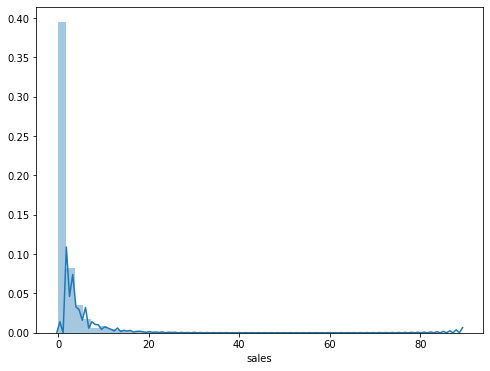

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_CA['sales'][:300000])

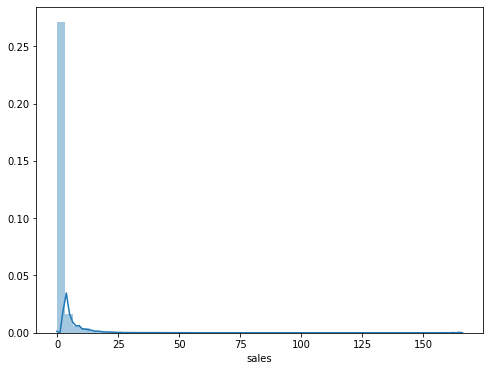

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_WI['sales'][:300000])

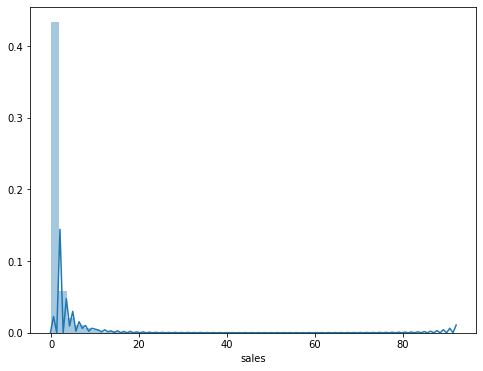

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_TX['sales'][:300000])

In [31]:
leave_size = 10
n_estimators = 1300

params_CA = {
        "objective" : "tweedie",
        'tweedie_variance_power': 1.075,
        "metric" :"rmse",
#         "force_row_wise" : True,
        "learning_rate" : 0.075,
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "feature_fraction": 1.0,
        "lambda_l2" : 0.1,
        "nthread" : 10,
        "metric": ["rmse"],
        'verbosity': 20,
        'num_leaves': 2**leave_size-1,
        "min_data_in_leaf": 2**(leave_size + 1)-1,
        "n_estimators": n_estimators
}

params_TX = {
        "objective" : "tweedie",
        'tweedie_variance_power': 1.2,
        "metric" :"rmse",
#         "force_row_wise" : True,
        "learning_rate" : 0.075,
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "feature_fraction": 1.0,
        "lambda_l2" : 0.1,
        "nthread" : 10,
        "metric": ["rmse"],
        'verbosity': 20,
        'num_leaves': 2**leave_size-1,
        "min_data_in_leaf": 2**(leave_size + 1)-1,
        "n_estimators": n_estimators
}

params_WI = {
        "objective" : "tweedie",
        'tweedie_variance_power': 1.1,
        "metric" :"rmse",
#         "force_row_wise" : True,
        "learning_rate" : 0.07,
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "feature_fraction": 1.0,
        "lambda_l2" : 0.1,
        "nthread" : 10,
        "metric": ["rmse"],
        'verbosity': 20,
        'num_leaves': 2**leave_size-1,
        "min_data_in_leaf": 2**(leave_size + 1)-1,
        "n_estimators": n_estimators
}

In [32]:
np.random.seed(777)

cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id', "event_name_1", "event_name_2", "event_type_1",  "event_type_2", 'snap']
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday", "revenue"]

for name, df, params in zip(['CA', 'TX', 'WI'], [df_CA, df_TX, df_WI], [params_CA, params_TX, params_WI]):
    
    train_cols = df.columns[~df.columns.isin(useless_cols)]
    X_train = df[train_cols]
    y_train = df["sales"]

    size_valid_set = len(df) // 10
    fake_valid_inds = np.random.choice(X_train.index.values, size_valid_set, replace = False)
    train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)
    
    X = X_train.loc[train_inds]
    y = y_train.loc[train_inds]

    print(f'Starting training {name} {params["tweedie_variance_power"]}')
    
    m_lgb = lgb.LGBMRegressor(**params)
    m_lgb.fit(X=X, y=y, 
              eval_set=[(X, y), (X_train.loc[fake_valid_inds], y_train.loc[fake_valid_inds])],
              eval_names=['train sales', 'valid sales'], 
              eval_metric=params['metric'],
              verbose=params['verbosity'],
              early_stopping_rounds=100,
              categorical_feature=cat_feats)
    m_lgb.booster_.save_model(str(path/f"m5_model_{name}.lgb"))

Starting training CA 1.075


/home/paperspace/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['cat_id', 'dept_id', 'event_name_1', 'event_name_2', 'event_type_1', 'event_type_2', 'item_id', 'snap', 'state_id', 'store_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[20]	train sales's rmse: 2.64509	valid sales's rmse: 2.73103
[40]	train sales's rmse: 2.40887	valid sales's rmse: 2.49887
[60]	train sales's rmse: 2.36102	valid sales's rmse: 2.4535
[80]	train sales's rmse: 2.31689	valid sales's rmse: 2.41403
[100]	train sales's rmse: 2.29576	valid sales's rmse: 2.39865
[120]	train sales's rmse: 2.27883	valid sales's rmse: 2.38645
[140]	train sales's rmse: 2.26383	valid sales's rmse: 2.3749
[160]	train sales's rmse: 2.25204	valid sales's rmse: 2.36764
[180]	train sales's rmse: 2.24167	valid sales's rmse: 2.36085
[200]	train sales's rmse: 2.23248	valid sales's rmse: 2.35624
[220]	train sales's rmse: 2.22286	valid sales's rmse: 2.34979
[240]	train sales's rmse: 2.21423	valid sales's rmse: 2.34489
[260]	train sales's rmse: 2.20662	valid sales's rmse: 2.34228
[280]	train sales's rmse: 2.19841	valid sales's rmse: 2.33859
[300]	train sales's rmse: 2.19181	valid sales's rmse: 2.33707
[320]	train sa

In [33]:
!tar -czvf {path/'m5_models.lgb'} {path/'m5_model_WI.lgb'} {path/'m5_model_TX.lgb'} {path/'m5_model_CA.lgb.tgz'} 

tar: Removing leading `/' from member names
/kaggle/m5_forecasting/m5_model_WI.lgb
/kaggle/m5_forecasting/m5_model_TX.lgb
/kaggle/m5_forecasting/m5_model_CA.lgb


## Predict

In [34]:
%%time

from tqdm.notebook import tqdm

sub = 0.
cols = [f"F{i}" for i in range(1,29)]
df = m5_common.create_dt(cal, prices, False, first_day=FIRST_DAY, path=path)
df_TX, df_WI, df_CA = extract_by_state(df)
max_lags = h * 4 + 1

all_results = []
for name, te in zip(['CA', 'TX', 'WI'], [df_CA, df_TX, df_WI]):
    m_lgb = lgb.Booster(model_file=str(path/f"m5_model_{name}.lgb"))
    for tdelta in tqdm(range(0, h), total=h):
        day = fday + timedelta(days=tdelta)
        print(name, tdelta, day)
        tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
        create_fea(tst)
        tst = tst.loc[tst.date == day, train_cols]
        te.loc[te.date == day, "sales"] = m_lgb.predict(tst)
        
    te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
    te_sub.loc[te.date >= fday+ timedelta(days=h), "id"] = te_sub.loc[te.date >= fday+timedelta(days=h), 
                                                                      "id"].str.replace("validation$", "evaluation")
    all_results.append(te_sub)
    
te_sub = pd.concat(all_results, axis=0, sort=False)

te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
te_sub.fillna(0., inplace = True)
te_sub.sort_values("id", inplace = True)
te_sub.reset_index(drop=True, inplace = True)
sub = te_sub


/home/paperspace/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


CA 0 2016-04-25 00:00:00


/home/paperspace/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


CA 1 2016-04-26 00:00:00
CA 2 2016-04-27 00:00:00
CA 3 2016-04-28 00:00:00
CA 4 2016-04-29 00:00:00
CA 5 2016-04-30 00:00:00
CA 6 2016-05-01 00:00:00
CA 7 2016-05-02 00:00:00
CA 8 2016-05-03 00:00:00
CA 9 2016-05-04 00:00:00
CA 10 2016-05-05 00:00:00
CA 11 2016-05-06 00:00:00
CA 12 2016-05-07 00:00:00
CA 13 2016-05-08 00:00:00
CA 14 2016-05-09 00:00:00
CA 15 2016-05-10 00:00:00
CA 16 2016-05-11 00:00:00
CA 17 2016-05-12 00:00:00
CA 18 2016-05-13 00:00:00
CA 19 2016-05-14 00:00:00
CA 20 2016-05-15 00:00:00
CA 21 2016-05-16 00:00:00
CA 22 2016-05-17 00:00:00
CA 23 2016-05-18 00:00:00
CA 24 2016-05-19 00:00:00
CA 25 2016-05-20 00:00:00
CA 26 2016-05-21 00:00:00
CA 27 2016-05-22 00:00:00



TX 0 2016-04-25 00:00:00
TX 1 2016-04-26 00:00:00
TX 2 2016-04-27 00:00:00
TX 3 2016-04-28 00:00:00
TX 4 2016-04-29 00:00:00
TX 5 2016-04-30 00:00:00
TX 6 2016-05-01 00:00:00
TX 7 2016-05-02 00:00:00
TX 8 2016-05-03 00:00:00
TX 9 2016-05-04 00:00:00
TX 10 2016-05-05 00:00:00
TX 11 2016-05-06 00:00:00
TX 12 2016-05-07 00:00:00
TX 13 2016-05-08 00:00:00
TX 14 2016-05-09 00:00:00
TX 15 2016-05-10 00:00:00
TX 16 2016-05-11 00:00:00
TX 17 2016-05-12 00:00:00
TX 18 2016-05-13 00:00:00
TX 19 2016-05-14 00:00:00
TX 20 2016-05-15 00:00:00
TX 21 2016-05-16 00:00:00
TX 22 2016-05-17 00:00:00


KeyboardInterrupt: 

In [35]:
%time

sub2 = sub.copy()
sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.to_csv("submission.csv",index=False)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


AttributeError: 'float' object has no attribute 'copy'

In [ ]:
sub

In [ ]:
!wc -l submission.csv